In [1]:
# markowitz_demo.py  — Full Markowitz Efficient Frontier (long-only)

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [8]:
# --------------------------
# Data utilities
# --------------------------
def get_price_frame(tickers, start=None, end=None):
    """Download prices and return a wide DataFrame of Adjusted Close (fallback to Close)."""
    data = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        col = "Adj Close" if "Adj Close" in set(lvl0) else "Close"
        prices = data[col].copy()
    else:
        col = "Adj Close" if "Adj Close" in data.columns else "Close"
        prices = data[[col]].copy()
        # If only one ticker, name the column with the ticker
        name = tickers[0] if isinstance(tickers, (list, tuple)) and len(tickers) == 1 else "PRICE"
        prices.columns = [name]
    prices = prices.dropna(how="all")
    return prices

def get_returns(prices, freq=252):
    """Percentage returns and annualized stats."""
    rets = prices.pct_change().dropna(how="all").dropna(axis=1)  # drop all-NaN cols
    mu = rets.mean() * freq
    cov = rets.cov() * freq
    # Align covariance with means (drop any symbols that didn't make it)
    cov = cov.loc[mu.index, mu.index]
    return rets, mu, cov

# --------------------------
# Portfolio math
# --------------------------
def portfolio_perf(w, mu, cov, rf=0.0):
    w = np.asarray(w)
    ret = w @ mu.values
    vol = np.sqrt(w @ cov.values @ w)
    sharpe = (ret - rf) / vol if vol > 0 else -np.inf
    return ret, vol, sharpe

def _bounds(n, short=False, max_w=0.10):         # set maximum position size so optimizer doesn't go nuts
    if short:
        return tuple((-max_w, max_w) for _ in range(n))
    else:
        return tuple((0.0, max_w) for _ in range(n))

def _constraints(mu):
    return ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)

def min_variance(mu, cov, short=False):
    n = len(mu)
    x0 = np.repeat(1/n, n)
    cons = _constraints(mu)
    res = minimize(lambda w: w @ cov.values @ w, x0,
                   method="SLSQP", bounds=_bounds(n, short), constraints=cons)
    return res.x

def max_sharpe(mu, cov, rf=0.0, short=False):
    n = len(mu)
    x0 = np.repeat(1/n, n)
    cons = _constraints(mu)
    def neg_sharpe(w):
        r, v, s = portfolio_perf(w, mu, cov, rf)
        return -s
    res = minimize(neg_sharpe, x0, method="SLSQP",
                   bounds=_bounds(n, short), constraints=cons)
    return res.x

def efficient_frontier(mu, cov, n_points=50, short=False):
    """Return (rets, vols, weights_list) along the min-variance frontier."""
    n = len(mu)
    x0 = np.repeat(1/n, n)
    cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

    # Target-return grid between low/high expected asset returns (clipped for stability)
    lo, hi = np.percentile(mu.values, 10), np.percentile(mu.values, 90)
    targets = np.linspace(lo, hi, n_points)

    rets, vols, ws = [], [], []

    for t in targets:
        cons = (cons_sum, {'type': 'eq', 'fun': lambda w, t=t: w @ mu.values - t})
        res = minimize(lambda w: w @ cov.values @ w, x0, method="SLSQP",
                       bounds=_bounds(n, short), constraints=cons)
        if res.success:
            w = res.x
            r, v, _ = portfolio_perf(w, mu, cov)
            rets.append(r); vols.append(v); ws.append(w)

    return np.array(rets), np.array(vols), ws

def target_vol_portfolio(mu, cov, target_vol, short=False, max_w=0.2, tol=1e-6):
    """
    Find the portfolio with *max expected return* at a chosen target volatility.
    mu: pd.Series of annualized expected returns
    cov: pd.DataFrame of annualized covariance
    target_vol: desired annualized volatility (e.g., 0.18 for 18%)
    """
    n = len(mu)
    x0 = np.repeat(1/n, n)

    def port_vol(w):
        return np.sqrt(w @ cov.values @ w)

    # Objective: maximize expected return  <-> minimize negative return
    def neg_ret(w):
        return -(w @ mu.values)

    # Constraints:
    cons = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},  # fully invested
        # hit target volatility (allow tiny tolerance)
        {'type': 'ineq', 'fun': lambda w: (target_vol + tol) - port_vol(w)},   # vol <= target+tol
        {'type': 'ineq', 'fun': lambda w: port_vol(w) - (target_vol - tol)}    # vol >= target-tol
    ]

    res = minimize(neg_ret, x0, method="SLSQP",
                   bounds=_bounds(n, short, max_w),
                   constraints=cons, options={'maxiter': 200})

    if not res.success:
        raise ValueError(f"Optimization failed: {res.message}")

    w = res.x
    r, v, s = portfolio_perf(w, mu, cov)
    return w, r, v, s

# --------------------------


=== Min-Variance Portfolio (long-only) ===
Ticker
DBC      0.1000
IEF      0.1000
GLD      0.1000
LQD      0.1000
XLP      0.1000
SPLV     0.1000
TLT      0.1000
XLV      0.1000
BRK-B    0.0960
EEM      0.0931
JPM      0.0110
EFA      0.0000
AAPL     0.0000
AMZN     0.0000
BABA     0.0000
MSFT     0.0000
META     0.0000
GOOG     0.0000
IWM      0.0000
QQQ      0.0000
PLTR     0.0000
MTUM     0.0000
NVDA     0.0000
SPY      0.0000
SOXL     0.0000
TSLA     0.0000
UUUU     0.0000
VNQ      0.0000
VLUE     0.0000
XLE      0.0000
XLU      0.0000
dtype: float64
Return: 4.821% | Vol: 9.022% | Sharpe: -0.02 (rf=5.00%)

=== Max-Sharpe Portfolio (long-only) ===
Ticker
BRK-B    0.1000
DBC      0.1000
GLD      0.1000
JPM      0.1000
XLU      0.1000
PLTR     0.1000
NVDA     0.1000
XLP      0.1000
XLE      0.1000
META     0.0726
IEF      0.0274
EFA      0.0000
EEM      0.0000
AMZN     0.0000
AAPL     0.0000
MSFT     0.0000
LQD      0.0000
GOOG     0.0000
IWM      0.0000
BABA     0.0000
SOXL     0.00

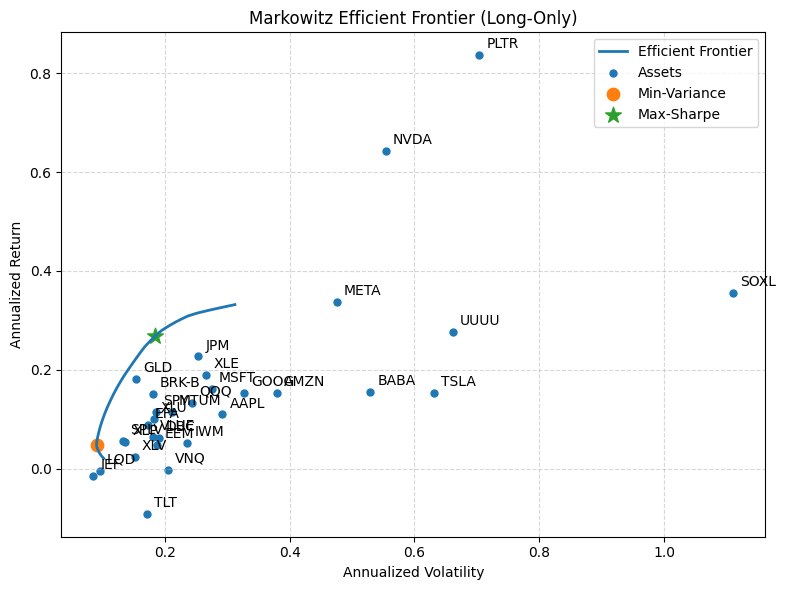

In [10]:

# --------------------------
# Demo / Run
# --------------------------
if __name__ == "__main__":
    # Use your tickers (same flavor as your heatmap)
    tickers = ["AAPL","AMZN","BABA","GOOG","JPM","MSFT","NVDA","QQQ","SOXL","SPY","TSLA","UUUU","META","PLTR","BRK-B",
               # diversification adds
                "SPLV","XLV","XLP","XLU",     # defensives/low-vol
                "IWM","VLUE","MTUM",          # style/size
                "EFA","EEM",                  # international
                "GLD","DBC","XLE",            # gold/commodities/energy
                "TLT","IEF","LQD","VNQ"       # bonds/REITs
            ]

    prices = get_price_frame(tickers, start="2022-01-01", end=None)
    returns, mu, cov = get_returns(prices)

    # Risk-free rate (annual). Adjust to taste.
    rf = 0.05

    w_mvp = min_variance(mu, cov, short=False)
    w_msr = max_sharpe(mu, cov, rf=rf, short=False)

    r_mvp, v_mvp, s_mvp = portfolio_perf(w_mvp, mu, cov, rf)
    r_msr, v_msr, s_msr = portfolio_perf(w_msr, mu, cov, rf)

    print("\n=== Min-Variance Portfolio (long-only) ===")
    print(pd.Series(w_mvp, index=mu.index).round(4).sort_values(ascending=False))
    print(f"Return: {r_mvp:.3%} | Vol: {v_mvp:.3%} | Sharpe: {s_mvp:.2f} (rf={rf:.2%})")

    print("\n=== Max-Sharpe Portfolio (long-only) ===")
    print(pd.Series(w_msr, index=mu.index).round(4).sort_values(ascending=False))
    print(f"Return: {r_msr:.3%} | Vol: {v_msr:.3%} | Sharpe: {s_msr:.2f} (rf={rf:.2%})")

    # Frontier
    f_rets, f_vols, _ = efficient_frontier(mu, cov, n_points=60, short=False)

    # Plot
    plt.figure(figsize=(8,6))
    # Efficient frontier
    plt.plot(f_vols, f_rets, linewidth=2, label="Efficient Frontier")

    # Individual assets
    asset_vols = np.sqrt(np.diag(cov.values))
    plt.scatter(asset_vols, mu.values, s=25, label="Assets")
    for i, t in enumerate(mu.index):
        plt.annotate(t, (asset_vols[i], mu.values[i]), xytext=(5, 5), textcoords="offset points")

    # Mark MVP and MSR
    plt.scatter([v_mvp], [r_mvp], marker="o", s=80, label="Min-Variance")
    plt.scatter([v_msr], [r_msr], marker="*", s=140, label="Max-Sharpe")

    plt.xlabel("Annualized Volatility")
    plt.ylabel("Annualized Return")
    plt.title("Markowitz Efficient Frontier (Long-Only)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

For a #based portfolio choose your own volatility and maximum position sizing based on your risk tolerance

In [14]:
# choose a target annualized volatility (e.g., 18%)
target_sigma = 0.18

# sanity check: must be ≥ min-variance vol
w_mvp = min_variance(mu, cov, short=False)
_, v_mvp, _ = portfolio_perf(w_mvp, mu, cov)

if target_sigma < v_mvp - 1e-6:
    print(f"Target vol {target_sigma:.2%} is below min-variance vol {v_mvp:.2%}. "
          "Increase target_sigma.")
else:
    w_tv, r_tv, v_tv, s_tv = target_vol_portfolio(mu, cov, target_sigma,      # max_w <= 0.1 for diversification
                                                  short=False, max_w=0.1)     # max_w > 0.1 can lead to concentrated portfolios
    print("Target-vol portfolio weights:\n",
          pd.Series(w_tv, index=mu.index).round(4).sort_values(ascending=False))
    print(f"Return: {r_tv:.2%} | Vol: {v_tv:.2%} | Sharpe: {s_tv:.2f}")

Target-vol portfolio weights:
 Ticker
BRK-B    0.100
DBC      0.100
GLD      0.100
JPM      0.100
XLU      0.100
PLTR     0.100
NVDA     0.100
XLP      0.100
XLE      0.100
META     0.057
IEF      0.043
EFA      0.000
EEM      0.000
AMZN     0.000
AAPL     0.000
MSFT     0.000
LQD      0.000
GOOG     0.000
IWM      0.000
BABA     0.000
SOXL     0.000
MTUM     0.000
QQQ      0.000
TLT      0.000
SPY      0.000
SPLV     0.000
TSLA     0.000
VNQ      0.000
VLUE     0.000
UUUU     0.000
XLV      0.000
dtype: float64
Return: 26.31% | Vol: 18.00% | Sharpe: 1.46


Now let's print out a chart of your position sizing

In [15]:
import matplotlib.pyplot as plt

def plot_allocation_pie(weights, tickers, title="Portfolio Allocation"):
    """
    Plot a pie chart of portfolio weights.
    weights: array-like of portfolio weights
    tickers: list of tickers (same length as weights)
    """
    weights = np.array(weights)
    tickers = np.array(tickers)

    # Only keep nonzero allocations (for clarity)
    mask = weights > 1e-4
    weights = weights[mask]
    tickers = tickers[mask]

    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts = ax.pie(
        weights,
        labels=tickers,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor":"white"}
    )
    ax.set_title(title, fontsize=14)
    plt.show()

In this iteration we are just using max position size of 10 percent. The optimizer loves to only take the very best assets and put you into them based on the periods performance. In later iterations I will not only optimize for individual stocks but also for sector

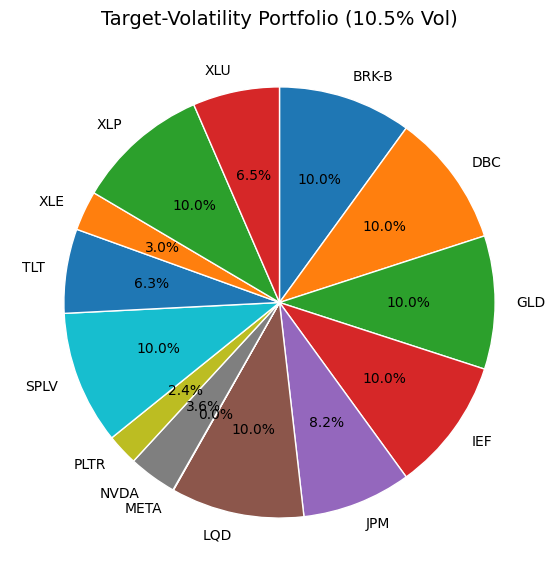

In [32]:
# Suppose you ran your optimizer:
target_sigma = 0.105
w_tv, r_tv, v_tv, s_tv = target_vol_portfolio(mu, cov, target_sigma, max_w=0.1)

# Plot the pie chart
plot_allocation_pie(w_tv, mu.index, title=f"Target-Volatility Portfolio ({v_tv:.1%} Vol)")